# **Step1: Design PBCN system for learning**

First we design the environment variables using the knowledge of PBCN parameters, dynamics and rewarding scheme. For other Markovian process that can be extracted from standard libraries like "gym" this step can be omitted.

Once the system is designed and the dynamics computed, we visualize attractors using "networkx" package, which also helps finding attractors in turn seggregating desired and undesired attractors.

**NOTE: We make use of decimal conventions (i.e., 111-7, 000-0, etc.) and Boolean control conventions (i.e., 111-1, 000-8, or 111-0, 000-7, etc. how to write?) as per our convenience in coding. The same will be specified when we switch and will follow unless changed again.**

Graph with combination U=00


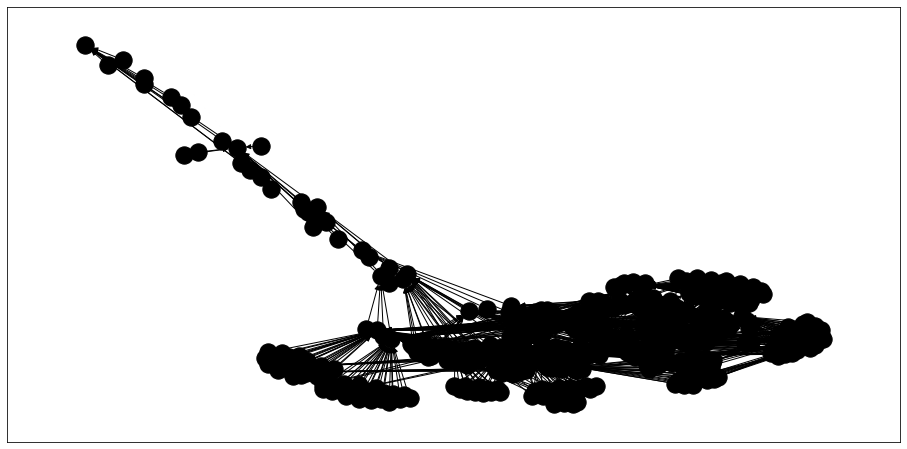

Graph with combination U=01


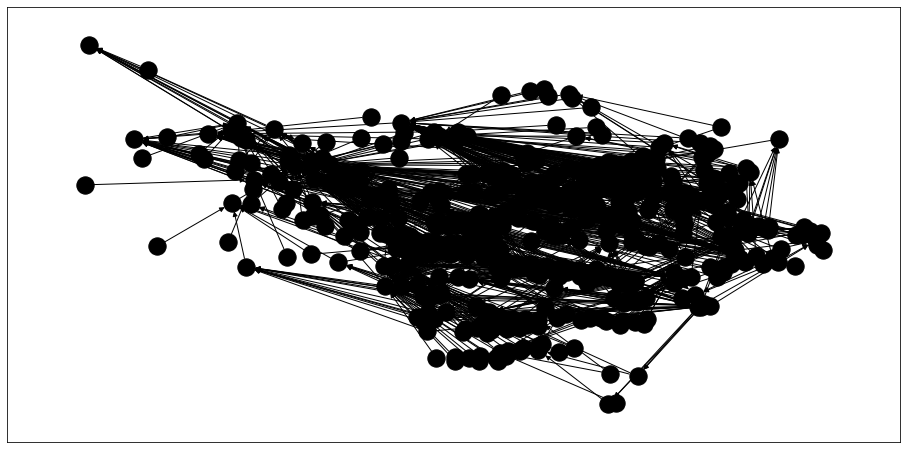

Graph with combination U=10


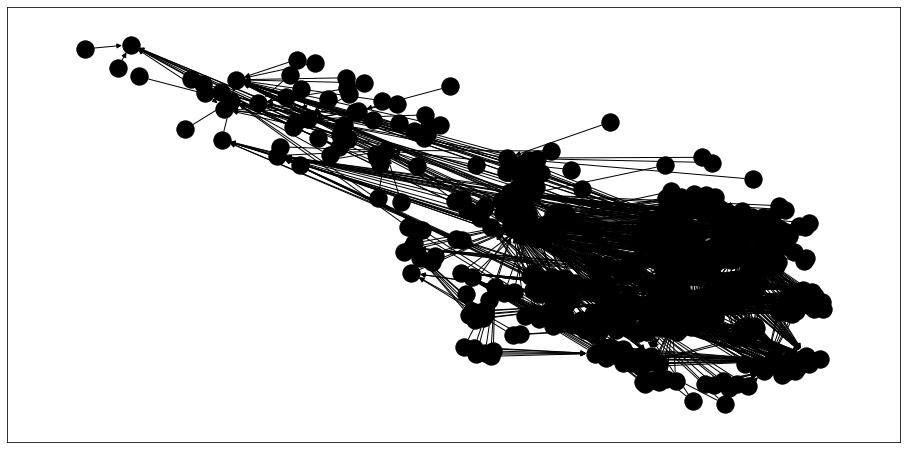

Graph with combination U=11


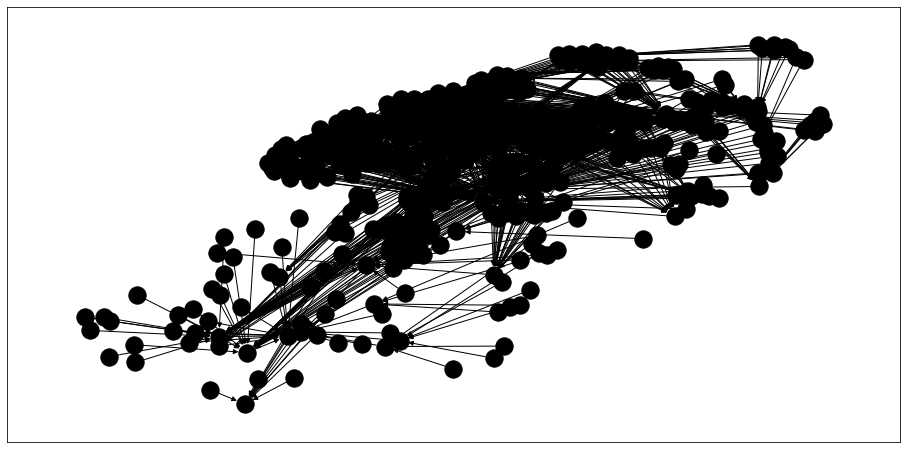

In [1]:
# Import libraries required for PBCN problem
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.model_selection import KFold
# from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
import multiprocessing as mp
import numpy as np
import pandas as pd
import random as rd
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import pylab as plt
import networkx as nx
import numpy as np
import time
import sys

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

ns = 9 # Number of State variables
nc = 2 # Number of Control variables
n = ns + nc # Total variables

# Generate table of all possible binary combinations between states-action pairs
table = list(itertools.product([0, 1], repeat=n))

# function to convert boolean to decimal values
def bool2dec(table_name,n_val,table_len,flag):
  dec_value=np.zeros(table_len)
  for i in range(0,table_len):
    for j in range(0,n_val):
      if flag==0:                           # flag defines if control u is taken into consideration or not
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j+nc]+dec_value[i] # for u at the beginning
      else:
        dec_value[i]=(np.power(2,(n_val-j-1)))*table_name[i][j]+dec_value[i] # for u at the beginning
  return dec_value

value=bool2dec(table,ns,len(table),0)
df=pd.DataFrame([table[0:len(table)],value])  # Dataframe comprising of state-action pairs and corresponding decimal values

no_of_perm = 4                              # no of possible permutations in reference to states possessing sub network structure
no_of_vars_with_diff_paths = 2              # no of variables possesing sub networks
if no_of_vars_with_diff_paths==1:
  f = np.zeros([ns+int(no_of_vars_with_diff_paths),df.shape[1]])    # f=[[f11f21f31],[f11f22f31],[f12f21f31]...] all possible dynamical functions
else:
  f = np.zeros([ns+int(no_of_perm/no_of_vars_with_diff_paths),df.shape[1]])     # f=[[f11f21f31],[f11f22f31],[f12f21f31]...] all possible dynamical functions

# Boolean dynamics of the system given by x_{k+1} = f_{x_{k},u_{k}}
for i in range(0,df.shape[1]):
  f[0,i]=(1-df[i][0][8]) and df[i][0][4]
  f[1,i]=df[i][0][2]
  f[2,i]=(1-df[i][0][0])
  f[3,i]=df[i][0][6] and df[i][0][7]
  f[4,i]=(1-df[i][0][0]) and df[i][0][3] and df[i][0][1]
  f[5,i]=df[i][0][6]
  f[6,i]=df[i][0][2]
  f[7,i]=(1-df[i][0][5]) and (1-df[i][0][9])
  f[8,i]=df[i][0][5] or df[i][0][6] or df[i][0][10]
  f[9,i]=(1-df[i][0][0]) and (df[i][0][6] or df[i][0][1])
  f[10,i]=df[i][0][10]

# creating and storing dataframes for individual sub networks
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[9,:]])
df2=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[9,:],bool2dec(dummy_df,ns,df.shape[1],1)])    # subnetwork with combination: sc1 = f11,f21,f31...f51...f91
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[9,:]])
df3=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[9,:],bool2dec(dummy_df,ns,df.shape[1],1)])    # subnetwork with combination: sc1 = f11,f21,f31...f52...f91
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[10,:]])
df4=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[4,:],f[6,:],f[7,:],f[8,:],f[10,:],bool2dec(dummy_df,ns,df.shape[1],1)])   # subnetwork with combination: sc1 = f11,f21,f31...f51...f92
dummy_df=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[10,:]])
df5=pd.DataFrame([f[0,:],f[1,:],f[2,:],f[3,:],f[5,:],f[6,:],f[7,:],f[8,:],f[10,:],bool2dec(dummy_df,ns,df.shape[1],1)])   # subnetwork with combination: sc1 = f11,f21,f31...f52...f92

# probability associated with fij
pc = np.ones(f.shape[0])
pc[0]=1.0
pc[1]=1.0
pc[2]=1.0
pc[3]=1.0
pc[4]=0.7
pc[5]=0.3
pc[6]=1.0
pc[7]=1.0
pc[8]=1.0
pc[9]=0.6
pc[10]=0.4


points_list_U1=list()     # transitions in decimal form with control u = 00
points_list_U2=list()     # transitions in decimal form with control u = 01
points_list_U3=list()     # transitions in decimal form with control u = 10
points_list_U4=list()     # transitions in decimal form with control u = 11
edge_weights_U1={}        # probabilities of transitions with control u = 00
edge_weights_U2={}        # probabilities of transitions with control u = 01
edge_weights_U3={}        # probabilities of transitions with control u = 10
edge_weights_U4={}        # probabilities of transitions with control u = 11

# notations indicating control chosen
control_dict={0:"u1=0,u2=0",
             1:"u1=0,u2=1",
             2:"u1=1,u2=0",
             3:"u1=1,u2=1",
            -1:"No Control"}

c = np.power(2,ns)
for i in range(np.power(2,ns)):                             # transitions are calculated in reference to the underlying dynamical equations and corresponding probabilities are stored
  points_list_U1.append((df[i].iloc[-1],df2[i].iloc[-1]))
  edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U1.append((df[i].iloc[-1],df3[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U1.append((df[i].iloc[-1],df4[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U1.append((df[i].iloc[-1],df5[i].iloc[-1]))
  if points_list_U1[-1] in points_list_U1[0:len(points_list_U1)-1]:
    edge_weights_U1[points_list_U1[-1]]=str(float(edge_weights_U1[points_list_U1[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U1[points_list_U1[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))

  points_list_U2.append((df[i+c].iloc[-1],df2[i+c].iloc[-1]))
  edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U2.append((df[i+c].iloc[-1],df3[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U2.append((df[i+c].iloc[-1],df4[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U2.append((df[i+c].iloc[-1],df5[i+c].iloc[-1]))
  if points_list_U2[-1] in points_list_U2[0:len(points_list_U2)-1]:
    edge_weights_U2[points_list_U2[-1]]=str(float(edge_weights_U2[points_list_U2[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U2[points_list_U2[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))

  points_list_U3.append((df[i+2*c].iloc[-1],df2[i+2*c].iloc[-1]))
  edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df3[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df4[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U3.append((df[i+2*c].iloc[-1],df5[i+2*c].iloc[-1]))
  if points_list_U3[-1] in points_list_U3[0:len(points_list_U3)-1]:
    edge_weights_U3[points_list_U3[-1]]=str(float(edge_weights_U3[points_list_U3[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U3[points_list_U3[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))  
  
  points_list_U4.append((df[i+3*c].iloc[-1],df2[i+3*c].iloc[-1]))
  edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df3[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[9],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df4[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[4]*pc[6]*pc[7]*pc[8]*pc[10],2))
  points_list_U4.append((df[i+3*c].iloc[-1],df5[i+3*c].iloc[-1]))
  if points_list_U4[-1] in points_list_U4[0:len(points_list_U4)-1]:
    edge_weights_U4[points_list_U4[-1]]=str(float(edge_weights_U4[points_list_U4[-1]])+np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  else:
    edge_weights_U4[points_list_U4[-1]]=str(np.round(pc[0]*pc[1]*pc[2]*pc[3]*pc[5]*pc[6]*pc[7]*pc[8]*pc[10],2))
  
# function to calculate possible attractors of the given PBCN
def find_Attractors(G,nx):
  number_of_attractor = nx.number_attracting_components(G)
  a_list = list(nx.attracting_components(G))
  return a_list

# Visualizing the graphs for u = 00
print("Graph with combination U=00")
GU1=nx.DiGraph()
GU1.add_edges_from(points_list_U1) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU1, with_labels=False, node_color ='black')
plt.show()

# Calculating and saving attractors for individual control actions
attractor_set = []
a_calc = find_Attractors(GU1,nx)
attractor_set.append(a_calc)

# Visualizing the graphs for u = 01
print("Graph with combination U=01")
GU2=nx.DiGraph()
GU2.add_edges_from(points_list_U2) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU2, with_labels=False, node_color ='black')
plt.show()

a_calc = find_Attractors(GU2,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# Visualizing the graphs for u = 10
print("Graph with combination U=10")
GU3=nx.DiGraph()
GU3.add_edges_from(points_list_U3) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU3, with_labels=False, node_color ='black')
plt.show()

a_calc = find_Attractors(GU3,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# Visualizing the graphs for u = 11
print("Graph with combination U=11")
GU4=nx.DiGraph()
GU4.add_edges_from(points_list_U4) 
plt.figure(figsize =(16, 8)) 
nx.draw_networkx(GU4, with_labels=False, node_color ='black')
plt.show()

a_calc = find_Attractors(GU4,nx)
if a_calc not in attractor_set:
  attractor_set.append(a_calc)

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Creating PBCN Parameters <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------


# **Step 2: Implementing RL based control**

For the current example, we implement all the state-of-the-art methods for evaluating competetive benchmark of the proposed QLRF algorithm.

0.0 % complete.
1.0 % complete.
2.0 % complete.
3.0 % complete.
4.0 % complete.
4.99 % complete.
5.99 % complete.
6.99 % complete.
7.99 % complete.
8.99 % complete.
9.99 % complete.
10.99 % complete.
11.99 % complete.
12.98 % complete.
13.98 % complete.
14.98 % complete.
15.98 % complete.
16.98 % complete.
17.98 % complete.
18.98 % complete.
19.98 % complete.
20.98 % complete.
21.97 % complete.
22.97 % complete.
23.97 % complete.
24.97 % complete.
25.97 % complete.
26.97 % complete.
27.97 % complete.
28.97 % complete.
29.97 % complete.
30.96 % complete.
31.96 % complete.
32.96 % complete.
33.96 % complete.
34.96 % complete.
35.96 % complete.
36.96 % complete.
37.96 % complete.
38.95 % complete.
39.95 % complete.
40.95 % complete.
41.95 % complete.
42.95 % complete.
43.95 % complete.
44.95 % complete.
45.95 % complete.
46.95 % complete.
47.94 % complete.
48.94 % complete.
49.94 % complete.
50.94 % complete.
51.94 % complete.
52.94 % complete.
53.94 % complete.
54.94 % complete.
55.94 % 

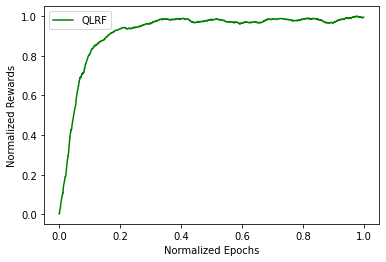

In [2]:

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing QLRF control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

# Model-free Reinforcement Learning

# --------******** Convention *******-----------

# 000 - 0
# 010 - 2
# 111 - 7

# --------******** Convention *******-----------


# Define parameters required for QLRF-training
num_nodes=np.power(2,ns)
goal=507                                              # desired attractor: 000-0
undesired_goals=[4,68]                               # undesired attractors: decimal - 1
EPSILON = 0.7
gamma = 0.8

# Environment variables
PTM=np.stack((edge_weights_U1,edge_weights_U2,edge_weights_U3,edge_weights_U4))     # Defining probability transitions matrix for function aprroximator learning

# Model-free Controller using QLRF-training
Q_algo=[]     # Initialize a dummy Q as a placeholder in greedy algo for QLRF
def greedy_policy(state,model_buff):
  data_buff=np.array([state_key[state]])
  data_regr=np.squeeze(model_buff.predict(data_buff))
  action_prob = np.ones(np.power(2,nc))*EPSILON/np.power(2,nc)         # define action probabilities as \epsilon/|A(s)|
  # choose best action to be a*=\underset{a\in A(s)}{\arg \max} Q
  best_action=np.squeeze(np.where(data_regr==np.max(data_regr)))
  if best_action.size>1:
    best_action = np.random.choice(best_action,size=1)
  action_prob[best_action]+=(1-EPSILON)                                # for a* set action probability = \epsilon/|A(s)| + (1-\epsilon)
  
  return action_prob

# Calc next_state on the basis of current state, and a greedy action for function approximator learning. [18*TPM, -0.01, -12*TPM, 15*TPM]; [18*TPM, -18*TPM, -18*TPM, 15*TPM]
def calc_reward(current_state,next_state,action):
  reward_buff=[]
  if next_state == goal:
    reward_buff = 5
  elif next_state in undesired_goals:
    reward_buff = -0.5
  elif (next_state not in undesired_goals) & (next_state != goal) & (next_state == current_state):
    reward_buff = -0.5
  else:
    reward_buff = 1*float(PTM[action][current_state,next_state])

  return float(reward_buff)

# Calc next_state on the basis of current state, and a greedy action for function approximator learning.
def calc_next_state(current_state,action):
  next_state_buff=[]
  reward_buff=[]
  for key1, key2 in PTM[action]:   # iter on both keys and values
    if key1==current_state:
      next_state_buff.append(key2)
      reward_buff.append(PTM[action][key1,key2])
  next_state = int(np.random.choice(next_state_buff,p=reward_buff,size=1))
  reward = calc_reward(current_state,next_state,action)

  return next_state, reward

# Define environment as: [current_state, next_state, action, reward] = env(current_state, Q_algo), where Q_algo is QLRF.
def env(current_state,model_buff):
  action_probabilities = greedy_policy(current_state,model_buff)                                  # calculate action probabilities using greedy policy
  action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)       # calculate action
  if action.size > 1:                      # if there are multiple actions choose any one randomly and for the chosen random action, choose single next_state if multiple transitions are possible
    action = int(np.random.choice(action,size=1))
    next_state, reward = calc_next_state(current_state, action)
  else:
    next_state, reward = calc_next_state(current_state, action)

  return np.array([current_state,next_state,action,reward])


# set a seed for rehearsing the results
seed = 0
np.random.seed(seed)

# initialise QLRF regressor with related parameters as per the number of samples to be inspected
max_depth = 4
if 'regressor' in locals():
  del regressor
regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=4,
                                                            max_depth=max_depth,
                                                            random_state=seed, warm_start=True))
# Initialise Standard scaler for data to be learnt
sc = StandardScaler()

# QLRF algorithm
def QLRF(RANDOM_TRANSITIONS_DATA_buff,regressor):
  
  Q_pred_qrf = np.zeros([np.power(2,ns),np.power(2,nc)])                                     # Initialize QLRF to zeros
    
  # generate D=(xn,yn) from state-action-value pairs from replay buffer
  data_buff = np.squeeze(RANDOM_TRANSITIONS_DATA_buff)
  # X = np.array([list(item) for item in np.array(data_buff[:,2])])
  X = state_key
  # y = np.array([item for item in data_buff[:,3]])
  y = sc.inverse_transform(regressor.predict(X))

  check=np.array([item.tolist() for item in data_buff[:,3]])
  for i in range(len(check)):
    y[int(data_buff[i,0]),:] = check[i]

  # Standardized the data for good predictions
  X = sc.fit_transform(X)
  Y = sc.fit_transform(y)

  # Fit the QLRF forest using the data extracted from Experience Replay buffer
  regressor = MultiOutputRegressor(RandomForestRegressor(n_estimators=4, random_state=seed, warm_start=True))
  regressor.fit(X, Y)

  # generate predictions using fitted random forest model and use inverse transform to generate unscaled original values
  y_pred = regressor.predict(X)
  y_pred = sc.inverse_transform(y_pred)

  # # remove rewards lower than or higher than a certain threshold in order to avoid bad predictions
  # for k in range(y_pred.shape[0]):
  #   if (y_pred[k,:].all()>REWARD_LB) and (y_pred[k,:].all()<=REWARD_UB):
  #     Q_pred_qrf[int(data_buff[k,0]),:] = y_pred[k,:]
  Q_pred_qrf = y_pred
  
  return Q_pred_qrf,regressor



# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------
start_time = time.time()                                            # start the timer to time overall code execution for all the three algorithms to train

# Initialize overall normalized score for all the three algorithms
scores_QLRF = []
# Initialize predict (Q) and target (\hat{Q}) for QRLF
Q_target_QLRF = np.zeros([np.power(2,ns),np.power(2,nc)])
Q_predict_QLRF = np.zeros([np.power(2,ns),np.power(2,nc)])
# set maximum replay buffer capacity or RB_{cap}
REPLAY_BUFFER_MAX = 4
# set number of parameters to be stored in replay buffer; i.e., current_state, next_state, action, reward
no_of_params_RB = 4
# initialize replay buffers for QLRF
REPLAY_BUFFER_QLRF = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
# set maximum iterations to train and batch size to be sampled
BATCH = 4
MAX_ITER = np.power(2,ns) + int(np.power(2,ns)/REPLAY_BUFFER_MAX) + (REPLAY_BUFFER_MAX-BATCH)*REPLAY_BUFFER_MAX + 34000 # Optimal iterations as number of states + (number of states/RB_{cap}) + extra steps, if required.
# initialize randomly sampled dataset for both the algorithms
RANDOM_TRANSITIONS_QLRF = np.zeros([BATCH,no_of_params_RB])
# define upper and lower bounds on rewards achieved, a very high negative and positive reward is chosen assuming there is no bad data predicted.
REWARD_LB = -1000
REWARD_UB = 1000
# initialize random transitions dataset D_i \in random_transitions dataset D according to defined batch size.
RANDOM_TRANSITIONS_DATA = []
# initialize targets for QLRF
TARGET = np.zeros([BATCH,np.power(2,nc)])
# initialize counts and state_key for corresponding states and action boolean values
cnt = 0
idx_cnt = 0
state_key = list(itertools.product([0, 1], repeat=ns))
state_key_c = list(itertools.product([0, 1], repeat=nc))
# initialise data buffer predicted by the models for calculating Q_{max} in each step
Q_target_data_buff=0
Q_target_data_buff_X=0

# initialise QLRF regressor with random data
X_dummy=state_key
Y_dummy=np.zeros([np.power(2,ns),np.power(2,nc)])
# Standardized the data for good predictions
X_dummy = sc.fit_transform(X_dummy)
Y_dummy = sc.fit_transform(Y_dummy)
regressor.fit(X_dummy,Y_dummy)

# Q_STP=np.array([[0,0,1,1,1,1,0,0],[1,1,0,0,0,0,1,1]])
# err_QLRF=[]

for j in range(MAX_ITER):

  # choose random current_state in every iterations and generated data for training DQN and QLRF using Q values
  current_state = num_nodes-1-j%num_nodes

  # generate replay buffers for DQN and QLRF learning
  REPLAY_BUFFER_QLRF[idx_cnt, :] = env(int(current_state), regressor)
  idx_cnt+=1
  cnt+=1
  
  # iteratre until replay buffer is completely filled and once the data is available train QLRF model
  if cnt%REPLAY_BUFFER_MAX==0 and cnt!=0:
    
    idx = np.random.randint(REPLAY_BUFFER_MAX, size=BATCH)    # choose random indexes of size batch from replay buffer
    # generate random transitions sample dataset for training 
    RANDOM_TRANSITIONS_QLRF = REPLAY_BUFFER_QLRF[idx, :]

    # for all the values in random transitions dataset train QLRF model
    for l in range(BATCH):
      # for QLRF we choose exploring all the states at any given state value allowing to fasten the training process
      for k in range(np.power(2,nc)):

        # with current state-action pairs generate target values for learning
        next_state, reward = calc_next_state(int(RANDOM_TRANSITIONS_QLRF[l,0]),k)

        # if next state == terminal: --> target = maximum reward else: --> target = r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a)
        # calculate Q_{max} using the best action being in current state
        if next_state == goal:
          TARGET[l,k] = reward
        else:
          Q_target_data_buff_X=np.array([state_key[int(next_state)]])
          Q_target_data_buff=np.squeeze(sc.inverse_transform(regressor.predict(Q_target_data_buff_X)))
          max_index=np.squeeze(np.where(Q_target_data_buff==np.max(Q_target_data_buff)))
          
          if max_index.size > 1:
              max_index = int(np.random.choice(max_index, size = 1))
          else:
              max_index = int(max_index)
          max_value = Q_target_data_buff[max_index]

          # target = r+\gamma \underset{a \in A(s)}{\arg \max} Q(s,a)
          TARGET[l,k] = reward+gamma*(max_value)

      # random transitions data comprises of current_state, action, binary key for transitions, target.
      RANDOM_TRANSITIONS_DATA.append(np.array([RANDOM_TRANSITIONS_QLRF[l,0],RANDOM_TRANSITIONS_QLRF[l,2],state_key[int(RANDOM_TRANSITIONS_QLRF[l,0])],TARGET[l,:]],dtype='object'))

    # predict Q values using QLRF algorithm and store values for computing MDP score.
    Q_target_QLRF,regressor=QLRF(RANDOM_TRANSITIONS_DATA,regressor)
    # for l in range(Q_predict_QLRF.shape[0]):
    #   for k in range(Q_predict_QLRF.shape[1]):
    #     if Q_predict_QLRF[l,k]!=0:                  # update target Q values using newer values in predict Q values and avoid bad predictions
    #       Q_target_QLRF[l,k] = Q_predict_QLRF[l,k] 
    
    # flush all the data from replay buffer and randomly sampled dataset
    idx_cnt = 0
    REPLAY_BUFFER_QLRF = np.zeros([REPLAY_BUFFER_MAX,no_of_params_RB])
    RANDOM_TRANSITIONS_DATA = []

    # calculate normalized rewards or scores for individual algorithms
    if (np.max(Q_target_QLRF) > 0):
      scores_pred = ((np.sum(Q_target_QLRF/np.max(Q_target_QLRF)*100)))
    else:
      scores_pred=0
    scores_QLRF.append(scores_pred)
    # err_QLRF.append(np.sum((np.argmax(Q_STP,axis=0)-np.argmax(Q_target_QLRF.T,axis=0))))

  # print overall progress of the training process.
  if j%(np.round(MAX_ITER/100)) == 0:
    print(np.round((j/MAX_ITER)*100,2),'% complete.')
  

# print total time taken for the overall training
print('Total time taken for training of all the three algorithms')
print("--- %s seconds ---" % (time.time() - start_time))

# generate normalized score from successive steps for checking the stability of learning
scores_QLRF = scores_QLRF/np.max(scores_QLRF)

# generate a linear x-space for plotting
t = np.linspace(0, 1, len(scores_QLRF))

# visualize the data
plt.plot(t, scores_QLRF, label='QLRF', color = 'green')
plt.xlabel('Normalized Epochs')
plt.ylabel('Normalized Rewards')
plt.legend()
plt.show()

# ------------------------>>>>>>>>>>>>>>>>> Training Module <<<<<<<<<<<<<<<<----------------------------

# Use this to generate Q-table from the learnt function approximator.

# sc.inverse_transform(regressor.predict(state_key))

# ---------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Defining and implementing RL control <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<----------------------------

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


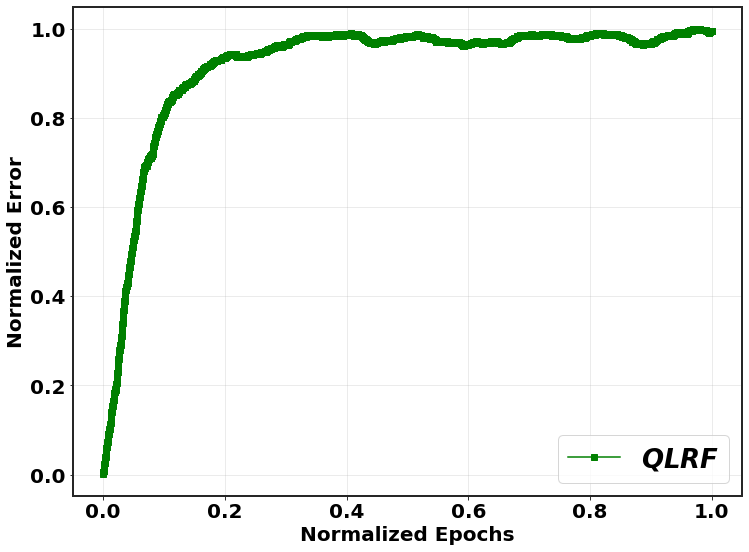

In [3]:
# Formatting the plots for better visualisation

t = np.linspace(0, 1, len(scores_QLRF))

plt.rcParams.update({'font.family': 'Times New Roman', 'font.size': 20, 'font.weight': 'bold'})
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 2
fig = plt.figure(figsize=(12, 9))

plt.plot(t, scores_QLRF, label=r'$QLRF$', color = 'green', marker='s')

plt.xlabel('Normalized Epochs',fontsize='20', fontweight='bold')
plt.ylabel('Normalized Error',fontsize='20', fontweight='bold')
plt.legend(prop={"size":26})
plt.grid(alpha=0.3)
plt.show()

np.save('scores_QLRF.npy',scores_QLRF)

fig.savefig('MDP_plot.png', dpi=300, bbox_inches = "tight")

Once the training is done, one can analyse the trained Q values using QLRF and verify its accuracy/optimality in terms of available state transition graphs.

In [4]:
# Generate heat-maps for analysis
import seaborn as sns

crms=np.transpose(Q_target_QLRF)      # In case of using multiple algorithms, individual Q tables can be replaced here in order to understand the values learnt

np.random.seed(24)
df_dummy = pd.DataFrame({'Q': np.linspace(0, 3, 4)})
df_dummy = pd.concat([df_dummy, pd.DataFrame(crms)],axis=1)

cm = sns.light_palette("blue", as_cmap=True)

s5 = df_dummy.style.background_gradient(cmap=cm)
s5

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


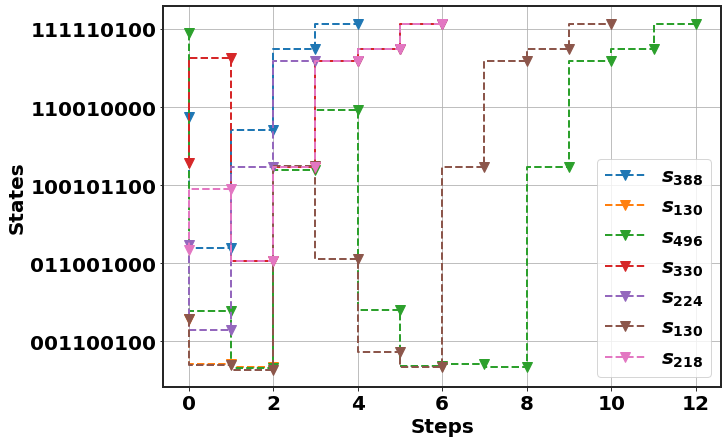

In [5]:
# Initialize Q tables for various algorithms

from matplotlib.ticker import StrMethodFormatter

Q_QLRF_10 = np.zeros(Q_target_QLRF.T.shape)
idx_QLRF = np.argmax(Q_target_QLRF,axis=1)

# Convert all the learnt Q tables into its Boolean equivalent, i.e., either 1 or 0.
for i in range(num_nodes):
  Q_QLRF_10[idx_QLRF[i],i] = 1

# Create a copy of the environment for testing both the algorithms
def env_copy(current_state, action):
  next_state = np.array([np.squeeze(np.where(PTM_copy[action,current_state,:]>0))])
  if next_state.size>1:
    action_prob_idx = np.nonzero(PTM_copy[action,current_state,:])
    next_state = int(np.random.choice(np.squeeze(np.where(PTM_copy[action,current_state,:]>0)),p=np.squeeze(PTM_copy[action,current_state,action_prob_idx]),size=1))
  else:
    next_state = int(np.squeeze(np.where(PTM_copy[action,current_state,:]>0)))

  return next_state

# Define parameters for the testing session
all_done = 0
# Defining tabular probability transition matrix for testing
probs_U1=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U2=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U3=np.zeros([np.power(2,ns),np.power(2,ns)])
probs_U4=np.zeros([np.power(2,ns),np.power(2,ns)])
for i in range(len(points_list_U1)):
  probs_U1[int(points_list_U1[i][0])][int(points_list_U1[i][1])]=edge_weights_U1[points_list_U1[i]]
for i in range(len(points_list_U2)):
  probs_U2[int(points_list_U2[i][0])][int(points_list_U2[i][1])]=edge_weights_U2[points_list_U2[i]]
for i in range(len(points_list_U3)):
  probs_U3[int(points_list_U3[i][0])][int(points_list_U3[i][1])]=edge_weights_U3[points_list_U3[i]]
for i in range(len(points_list_U4)):
  probs_U4[int(points_list_U4[i][0])][int(points_list_U4[i][1])]=edge_weights_U4[points_list_U4[i]]
PTM_copy = np.stack((probs_U1,probs_U2,probs_U3,probs_U4))
steps_QLRF_buff = []             # List that stores steps taken by the agent using QLRF control
steps_QLRF = []                  # List that stores steps taken by the agent using QLRF control
# initialize the current state and let the agent start at the same point so as to perform peer-to-peer comparison
current_state = np.random.randint(num_nodes)
current_state_qlrf = current_state

for i in range(7):
  current_state_qlrf = np.random.randint(num_nodes)
  steps_QLRF_buff=[]
  steps_QLRF_buff.append(current_state_qlrf)
  all_done = 0

  while all_done != 1:                                          # perform actions until both the control actions help their respective agents reach the attractor

    # QLRF-based episode
    action = np.argmax(Q_QLRF_10[:,current_state_qlrf])
    next_state = env_copy(int(current_state_qlrf), int(action))
    steps_QLRF_buff.append(next_state)
    current_state_qlrf = next_state

    if (current_state_qlrf == goal):
      all_done += 1

  steps_QLRF.append(steps_QLRF_buff)

fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.yaxis.set_ticks(np.arange(0, np.power(2,ns), 100))
for i in range(7):
  ax.step(np.linspace(0,len(steps_QLRF[i])-1,len(steps_QLRF[i])), steps_QLRF[i], label=r'$s_{i}$'.format(i={int(steps_QLRF[i][0]+1)}), marker = 'v', markersize = 10, linewidth=2, linestyle='dashed')
  ax.yaxis.set_major_formatter(StrMethodFormatter("{x:09b}"))
  ax.set_ylabel('States', fontsize='20', fontweight='bold')
  ax.set_xlabel('Steps', fontsize='20', fontweight='bold')
ax.grid()
ax.legend(prop={"size":20}, loc="lower right")
 

np.save('steps_QLRF.npy',steps_QLRF)

fig.savefig('steps_QLRF.png', dpi=300, bbox_inches = "tight")